In [ ]:
#This is my attempt to re-create:
#Learning representations by back-propagating errors (1986), Rumelhart, Hinton, and Williams

In [ ]:
import random
import math
import numpy as np
from array import *
import matplotlib.pyplot as plt
import time

In [ ]:
class Node:

  def __init__(self, initial_value):
    self.value = initial_value
    self.mult = 0.0
    self.gradient = 0.0
    self.prev_gradient = 0.0

  def __add__(self, other):
    other = other.value if type(self)==type(other) else other
    out = self.value + other
    return out

  def __radd__(self, other):
    return self + other

  def __iadd__(self, other):
    other = other if type(self)==type(other) else Node(other)
    self.value += other.value
    return self

  def __mul__(self, other):
    other = other.value if type(self)==type(other) else other
    self.mult = other
    out = self.value * other
    return out

  def __rmul__(self, other):
    return self * other

  def copy(self):
    out = Node(self.value)
    out.mult = self.mult
    out.gradient = self.gradient
    return out

  def __repr__(self):
    #return f"value={self.value}, mult={self.mult}, gradient={self.gradient}"
    return f"{self.value}"

In [ ]:
# def sigmoid(x):
#   return 1/(1 + np.exp(-min(x, 37)))

# def sigmoid_derivative(x):
#   s_x = sigmoid(x)
#   return s_x*(1.0 - s_x)

def sigmoid(x):
  return x if x > 0 else .01 * x

def sigmoid_derivative(x):
  return 1 if x > 0 else .01

In [ ]:
class Neuron:

  def __init__(self, weights_per_neuron):
    lower_limit = -.3;
    upper_limit = .3;
    self.weights = [Node(random.uniform(lower_limit, upper_limit)) for _ in range(weights_per_neuron)];
    self.bias = Node(-1.0);
    self.size = weights_per_neuron;
    self.sum = Node(0.0)

  def feed_forward(self, previous_activations):
    out = 0.0
    for i in range(self.size):
      out += self.weights[i] * previous_activations[i]
    out = out + self.bias
    self.sum = Node(out)
    return sigmoid(out)

  def gradient(self, previous_gradient):
    self.sum.gradient = sigmoid_derivative(self.sum.value) * previous_gradient
    weights_mult_gradient = np.array([0.0 for _ in range(self.size)])
    for i in range(self.size):
      self.weights[i].gradient += self.sum.gradient * self.weights[i].mult
      weights_mult_gradient[i] = self.sum.gradient * self.weights[i]
    self.bias.gradient += self.sum.gradient

    return weights_mult_gradient

  def back_propigate(self, a, g):
    for i in range(self.size):
      dw = -a * self.weights[i].gradient + g * self.weights[i].prev_gradient
      self.weights[i].value += dw
      self.weights[i].prev_gradient = dw
    db = -a * self.bias.gradient + g * self.bias.prev_gradient
    self.bias.value += db
    self.bias.prev_gradient = db

  def zero_gradient(self):
    for i in range(self.size):
      self.weights[i].gradient = 0.0
    self.bias.gradient = 0.0

  def __repr__(self):
    return f"{self.weights} {self.bias}"


In [ ]:
class Layer:

  def __init__(self, weights_per_neuron, number_of_neurons):
    self.layer = [Neuron(weights_per_neuron) for _ in range(number_of_neurons)]
    self.size = number_of_neurons


  def feed_forward(self, previous_activations):
    activations = np.array([])
    for i in range(self.size):
      activations = np.append(activations, self.layer[i].feed_forward(previous_activations))
    return activations

  def gradient(self, previous_layer_gradients):
    layer_gradients = np.array([0.0 for _ in range(self.layer[0].size)])
    for i in range(self.size):
      layer_gradients += self.layer[i].gradient(previous_layer_gradients[i])
    return layer_gradients

  def back_propigate(self, a, g):
    for i in range(self.size):
      self.layer[i].back_propigate(a, g)

  def zero_gradient(self):
    for i in range(self.size):
      self.layer[i].zero_gradient()

  def print_layer(self):
    for i in range(self.size):
      print(f"{self.layer[i]}")
    print("\n")


In [ ]:
class NeuralNetwork:

  def __init__(self, size):
    for i in range(0, len(size)-1, 1):
      if (size[i][1] != size[i+1][0]):
        raise Exception("Size array invalid!")

    self.network = [Layer(l[0], l[1]) for l in size]
    self.size = len(size)

  def feed_forward(self, input):
    activations = np.array(input)
    for i in range(self.size):
      temp = self.network[i].feed_forward(activations)
      activations = temp.copy()

    return activations

  def predict(self, x_data):
    predictions = np.array([])
    for i in x_data:
      predictions = np.append(predictions, self.feed_forward(i))
    return predictions

  def gradient(self, dE_dOutput):
    last_layer_gradient = np.array([dE_dOutput for _ in range(self.network[self.size-1].size)])
    previous_layer_gradients = self.network[self.size-1].gradient(last_layer_gradient)

    if (self.size < 2):
        return

    for i in range(self.size-2, -1, -1):
      temp = self.network[i].gradient(previous_layer_gradients)
      previous_layer_gradients = temp.copy()

  def zero_gradient(self):
    for i in range(self.size):
      self.network[i].zero_gradient()

  def back_propigate(self, a, g):
    for i in range(self.size):
      self.network[i].back_propigate(a, g);

  def print_network(self):
    for i in range(NN.size):
      NN.network[i].print_layer()
      print()


In [ ]:
def print_graph(y_pred):
  global x_values, y_train

  # Plotting the first line
  plt.plot(x_values, y_train, label='Real')

  # Plotting the second line
  plt.plot(x_values, y_pred, label='Pred')

  # Adding labels and title
  plt.xlabel('X-axis Label')
  plt.ylabel('Y-axis Label')
  plt.title('2D Line Graph with Two Lines')

  # Adding a legend
  plt.legend()

  # Display the plot
  plt.show()

In [ ]:
def epoch(a, g, start, finish):
  global X_train, y_train, NN, indicies
  NN.zero_gradient()
  y_values = list()

  predictions = list()
  for i in range(start, finish, 1):
    pred = NN.feed_forward(X_train[indicies[i]])[0]
    predictions.append(pred)
    NN.gradient(pred - y_train[indicies[i]])
    y_values.append(y_train[indicies[i]])

  NN.back_propigate(a, g)
  loss = cost(predictions, y_values)
  return loss

In [ ]:
def fit(a, g, method=""):
  global X_train, y_train, NN

  if (method=="sgd"):
    batch_size = 32
    end = int(len(X_train)/batch_size) * batch_size

    for i in range(0, end, batch_size):
      start = 0
      finish = start + batch_size
      loss = epoch(a, g, start, finish)

    loss = epoch(a, g, finish, len(X_train))
  elif (method=="full"):
    loss = epoch(a, g, 0, len(X_train))
  else:
    predictions = list()
    for i in range(len(X_train)):
      NN.zero_gradient()
      pred = NN.feed_forward(X_train[i])[0]
      predictions.append(pred)
      NN.gradient(pred - y_train[i])
      NN.back_propigate(a, g)

    loss = cost(predictions, y_train)

  return loss

In [ ]:
def cost(y_pred, y_real):
  loss = 0.0
  for i in range(len(y_pred)):
    loss += .5*(y_pred[i] - y_real[i])**2
  return loss

In [ ]:
input_size = 16

In [ ]:
X_train = list()
x_values = list()
y_train = list()
indicies = np.array([], dtype=int)

for i in range(501):
  num = -2.0 + i*.008
  indicies = np.append(indicies, i)
  x_values.append(num)
  X_train.append([num for _ in range(input_size)])
  #y_train.append(1.0 * num)
  y_train.append(np.power(num, 3.0))

In [ ]:
# np.random.shuffle(indicies)

In [ ]:
NN = NeuralNetwork([[input_size, 8], [8, 1]])

In [ ]:
# First problem: Detect symmetry in input vector
#x_values = np.array([14.2, -3.6, 7.2, -7.2, 3.6, -14.2, -14.2, 3.6, -7.1, 7.1, -3.6, 14.2])
# x_values = [14.2, 3.6, 7.2, 7.1]
# x_values

In [ ]:
NN.print_network()

[-0.2558768584312302, -0.27079972751035974, 0.10380488915527064, -0.19980451773078423, -0.022840792199926074, 0.13692322374100274, -0.2174988653750513, 0.13033437704115203, 0.03863531379428892, -0.08381318449001565, -0.08126502446568681, -0.07603419715690624, 0.252839772953608, 0.2916472036866566, -0.16100017438249642, 0.07505827463254422] -1.0
[-0.21836293655054567, 0.18904886926152692, 0.2396194711157668, -0.15797649109247516, -0.2515998678415143, 0.11769054454009237, -0.2531108727737383, 0.07308766449447579, -0.06738259914169797, 0.18056006037614697, 0.11035099043601937, 0.04062945224276543, 0.09572418774118113, -0.060335474318314875, 0.29849099573545196, 0.029858387447123547] -1.0
[0.010692693250291208, -0.223066958835845, -0.2905934826023105, -0.01845385561357915, -0.04455317023582034, 0.256687237694817, -0.23589379668831886, 0.03579905657558047, -0.26836280350932024, -0.10497633997139277, -0.028148935616875148, 0.17980033469624268, 0.17612133077126235, 0.04609810575144058, 0.0953

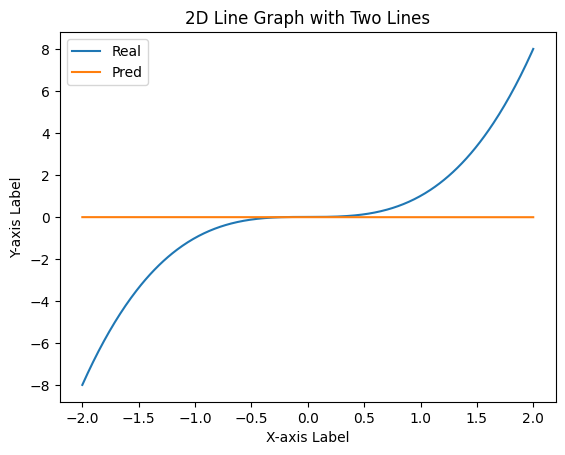

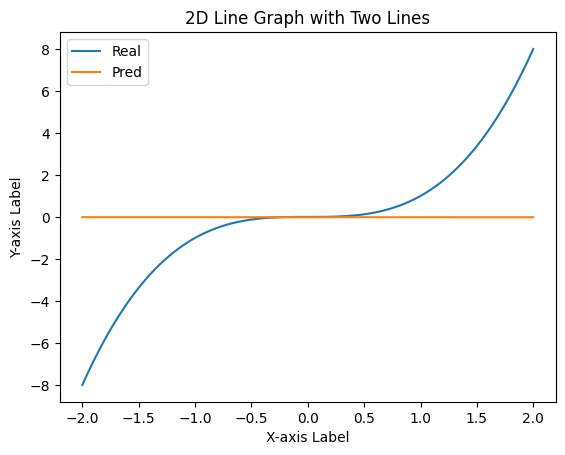

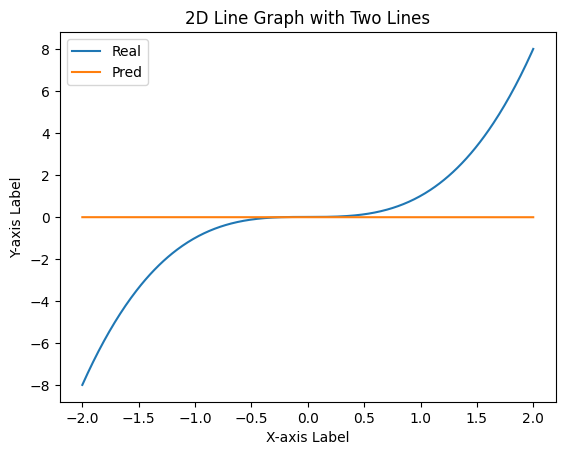

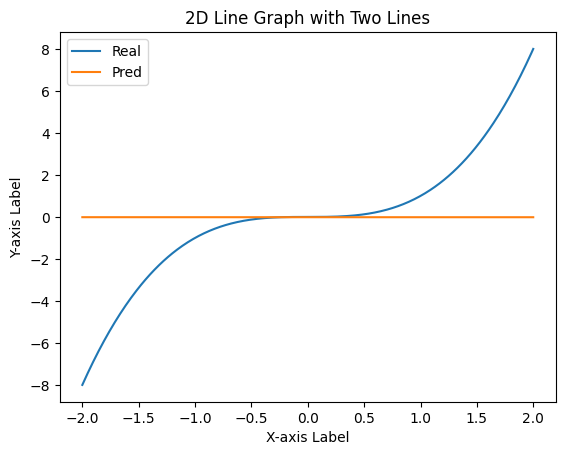

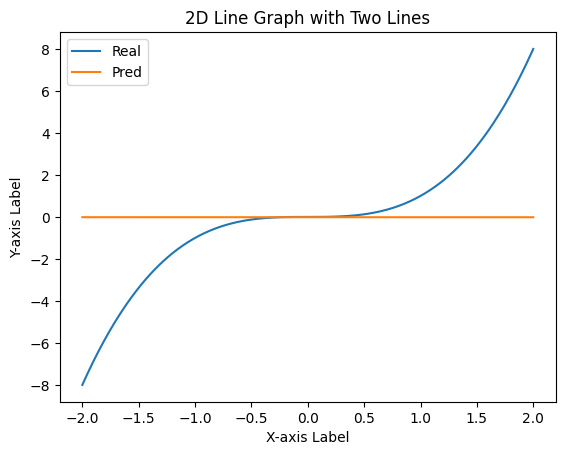

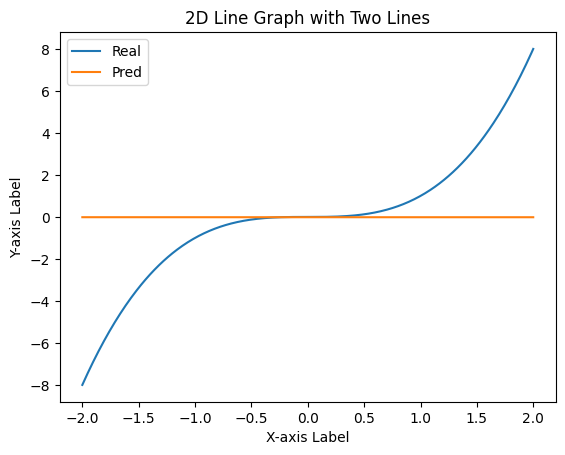

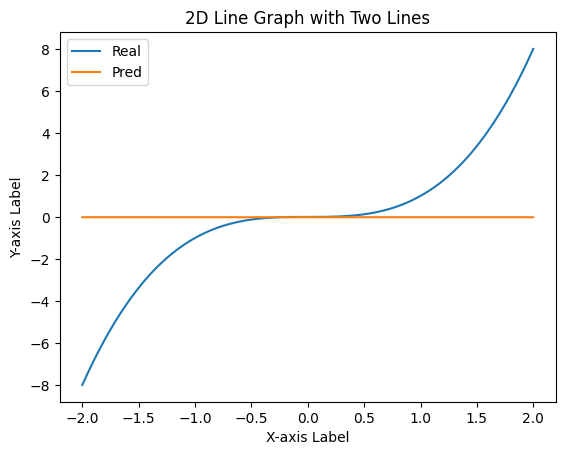

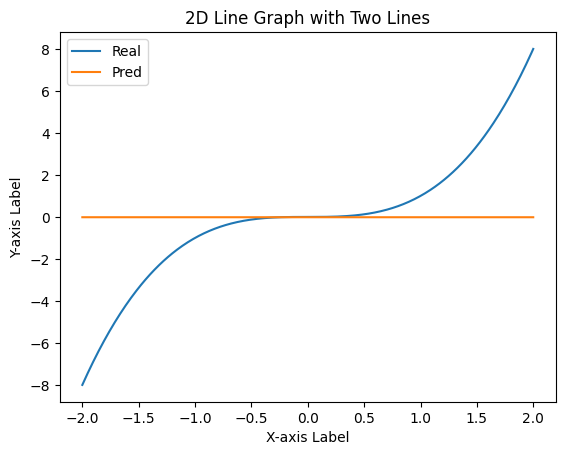

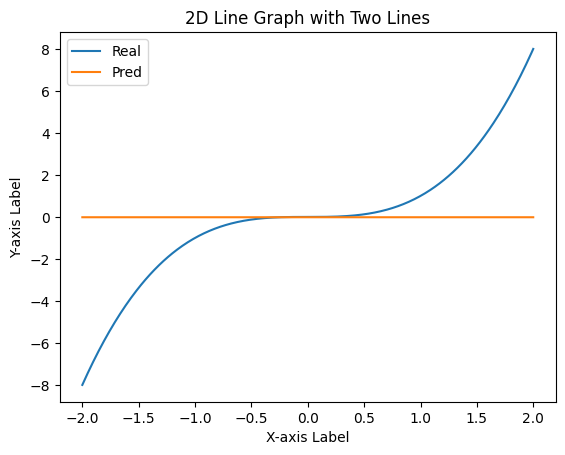

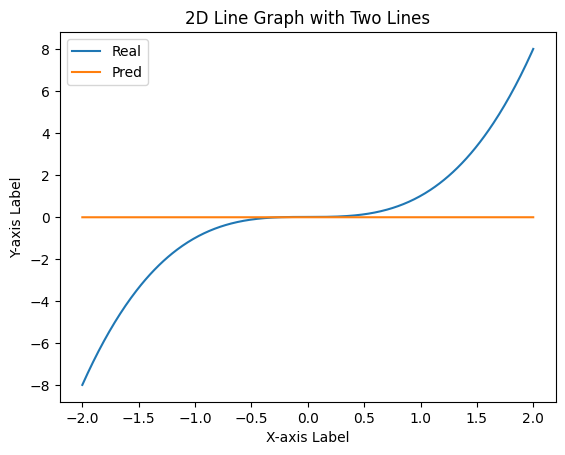

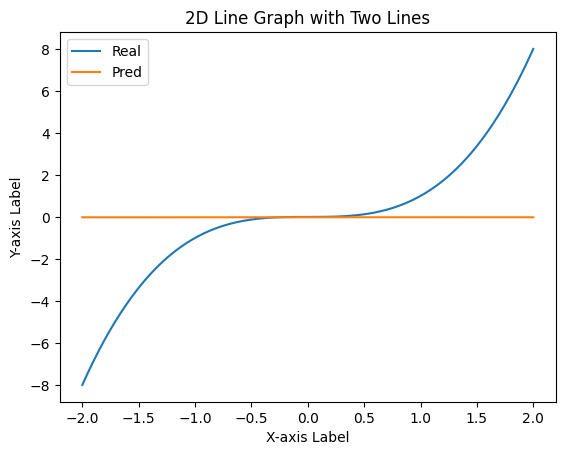

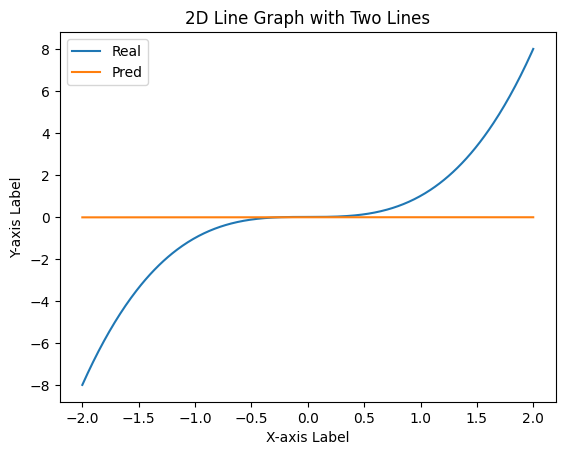

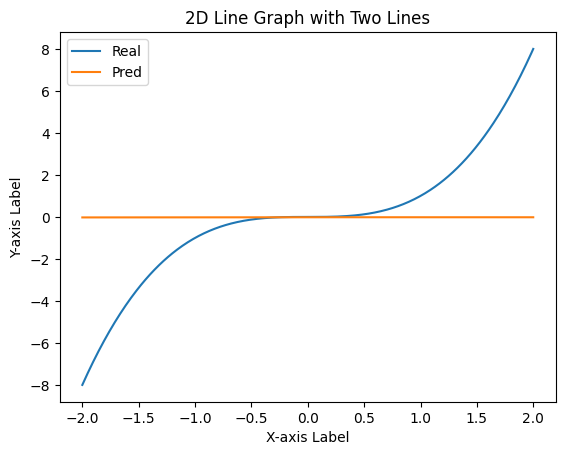

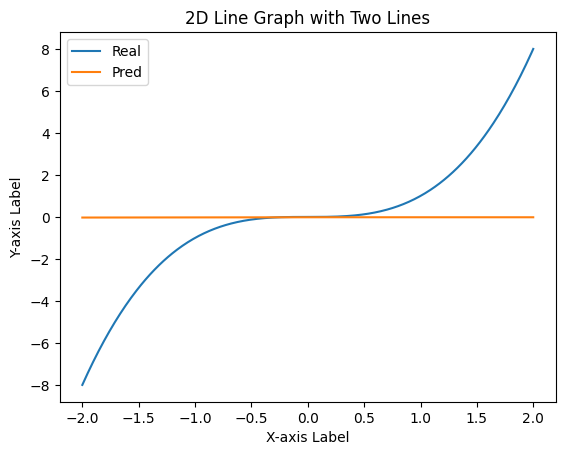

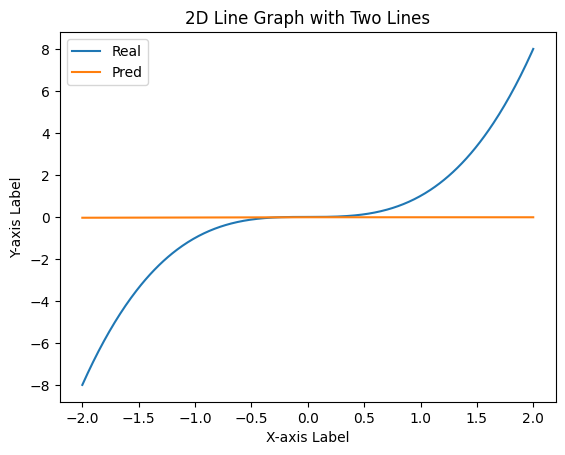

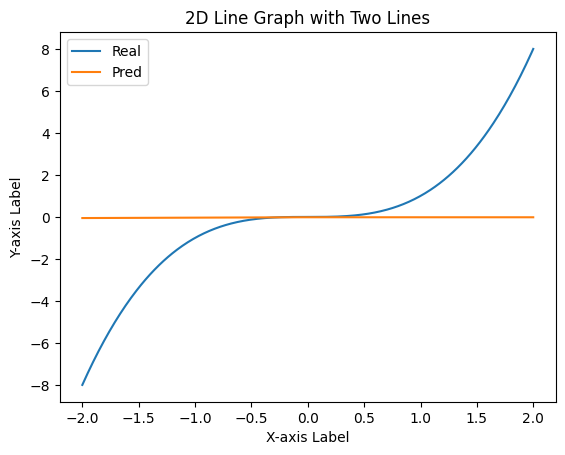

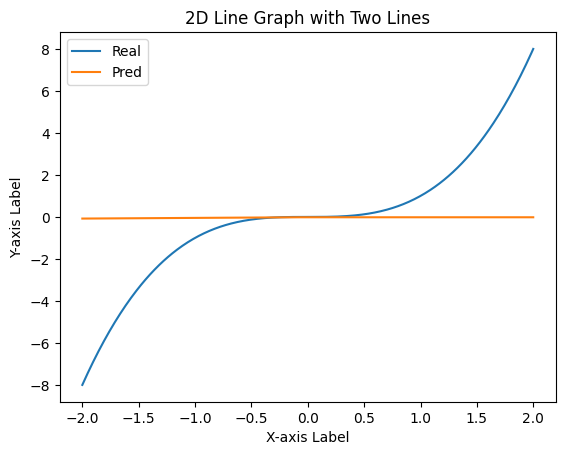

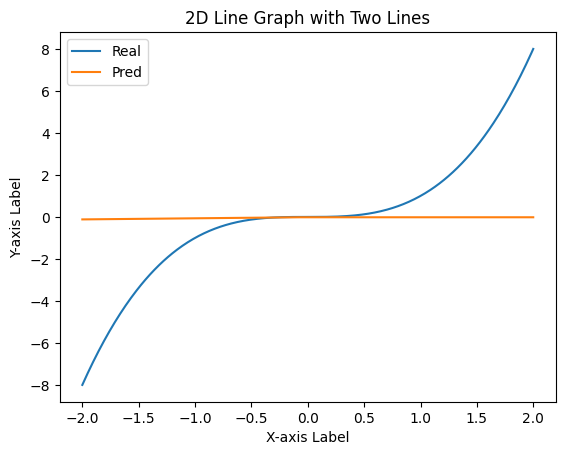

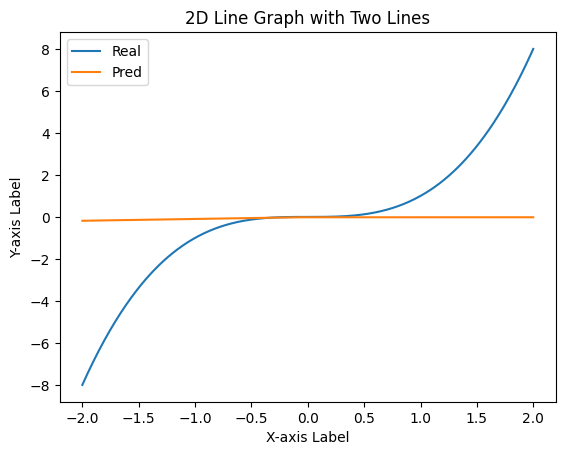

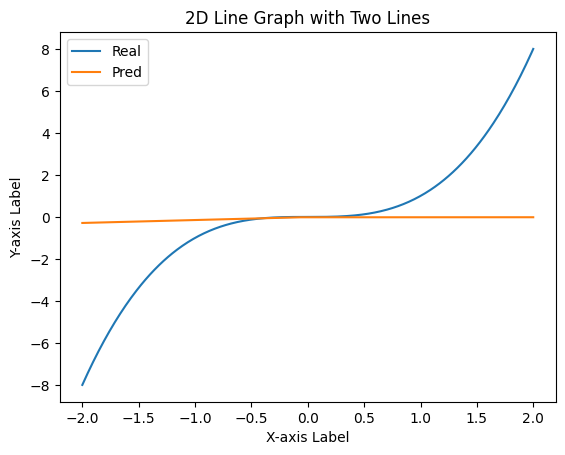

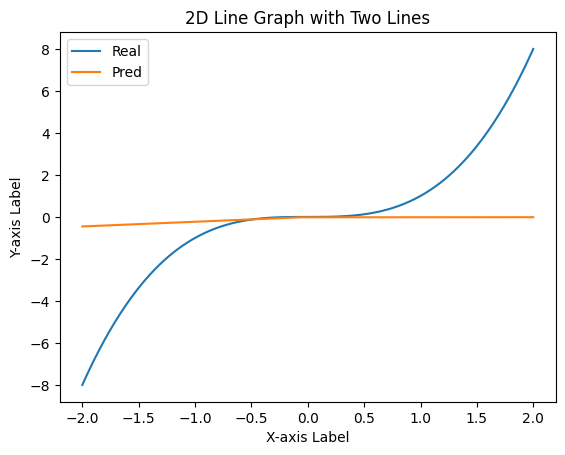

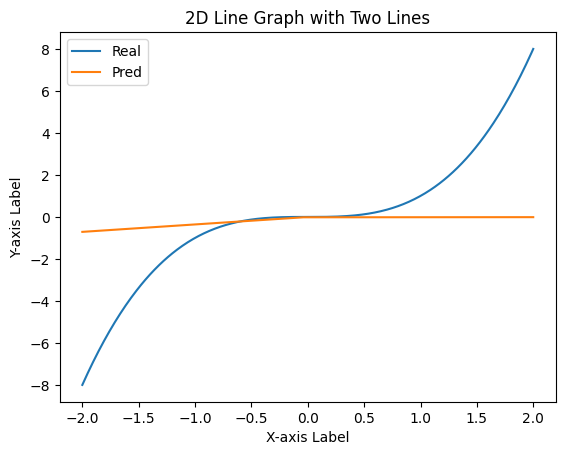

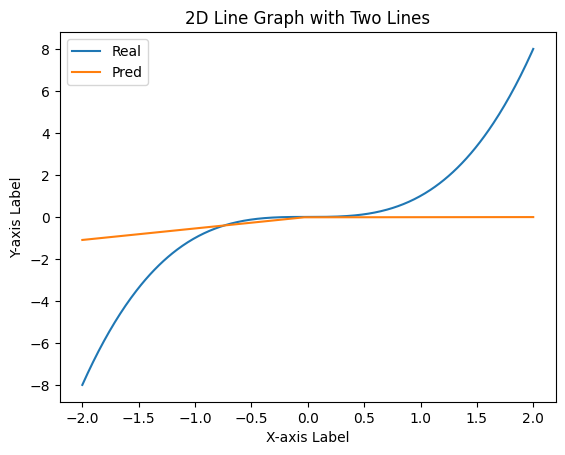

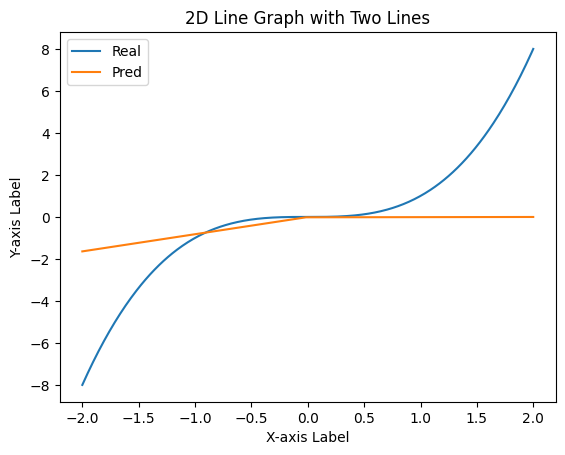

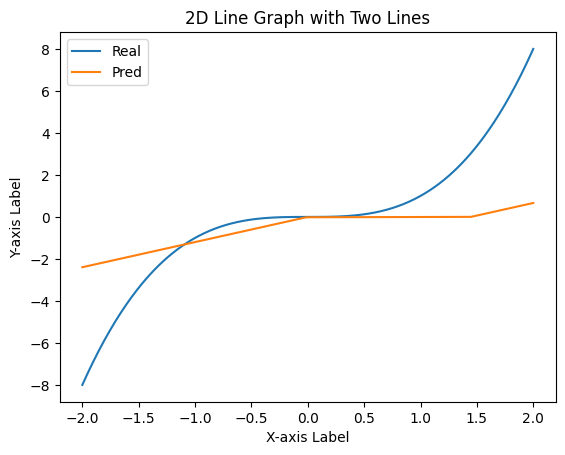

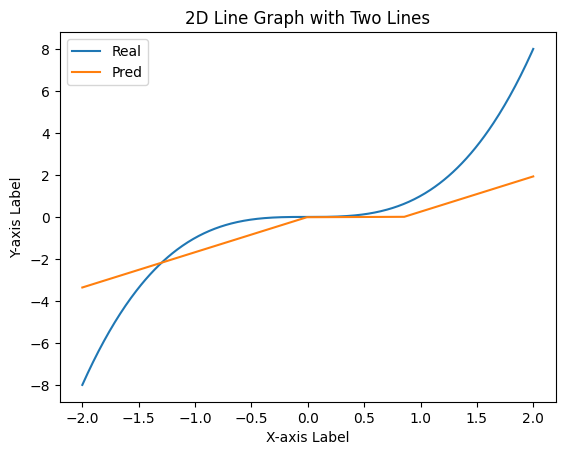

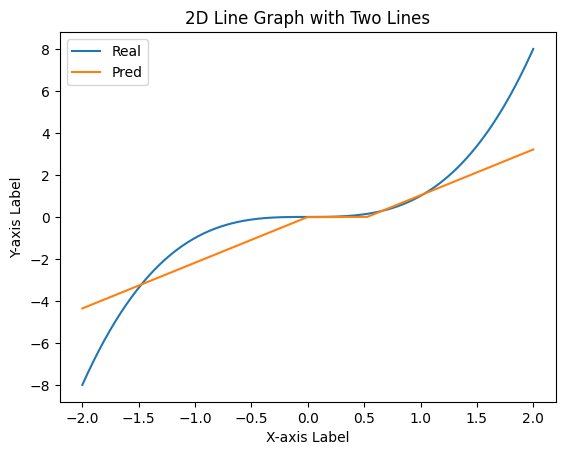

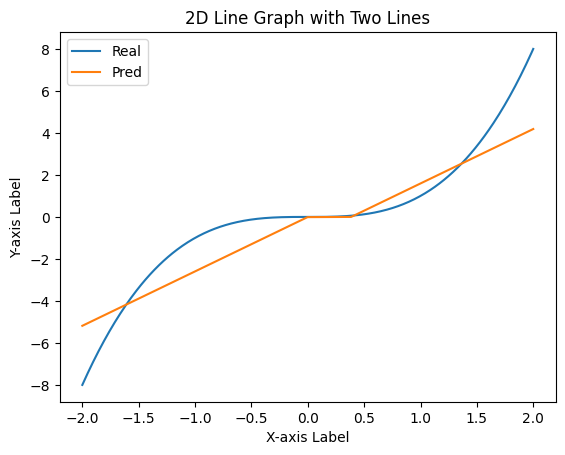

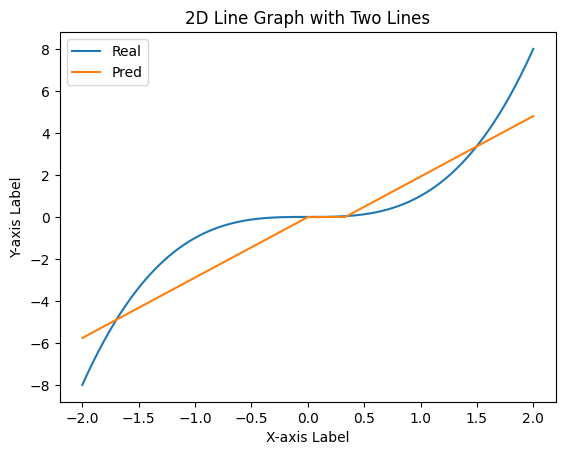

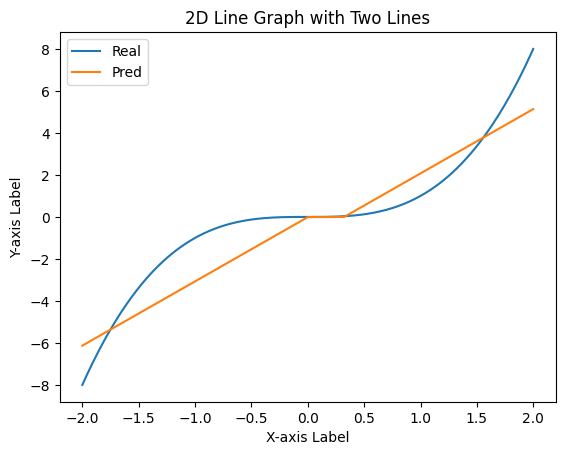

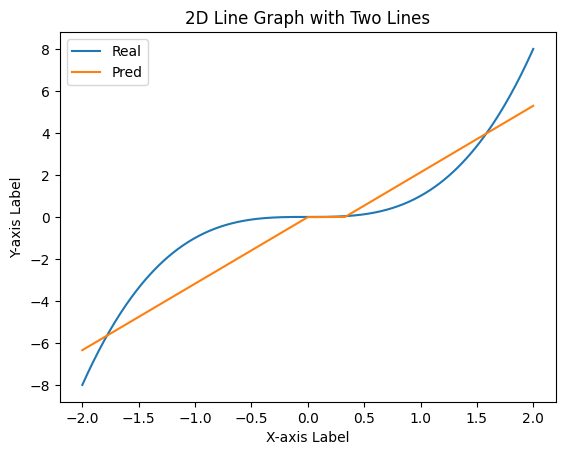

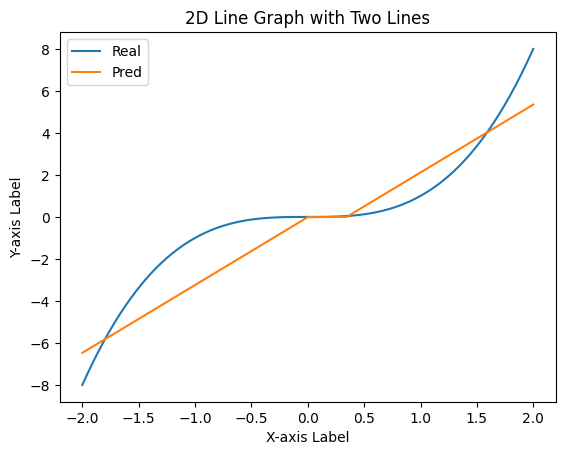

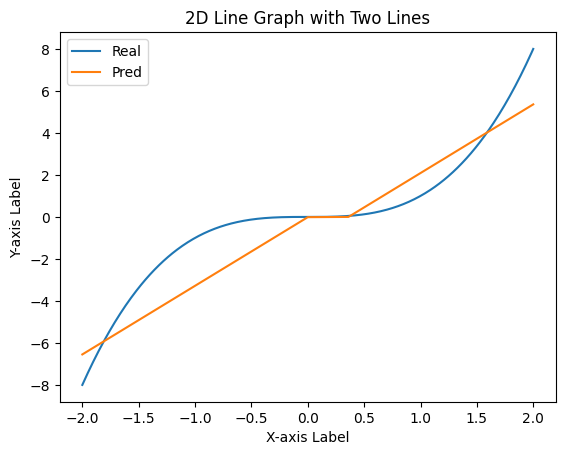

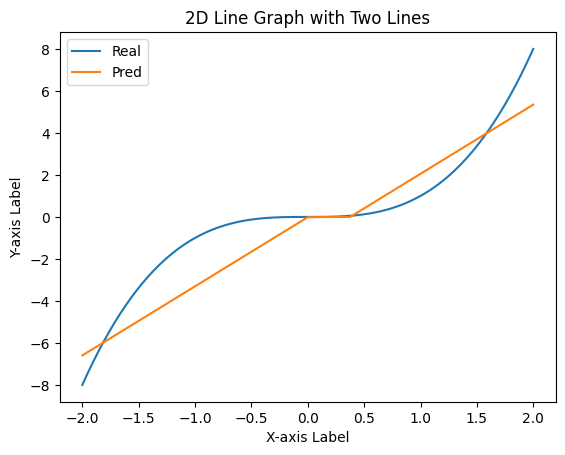

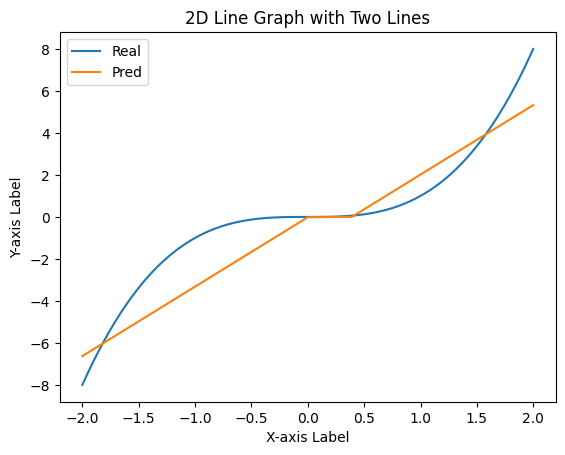

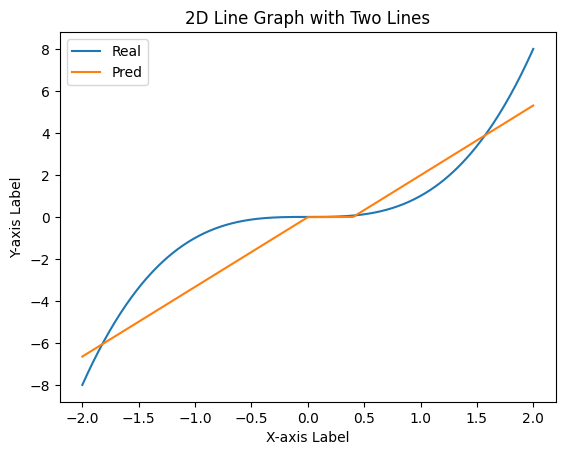

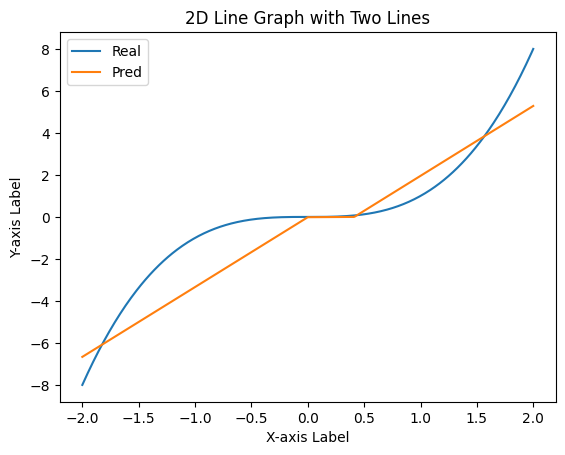

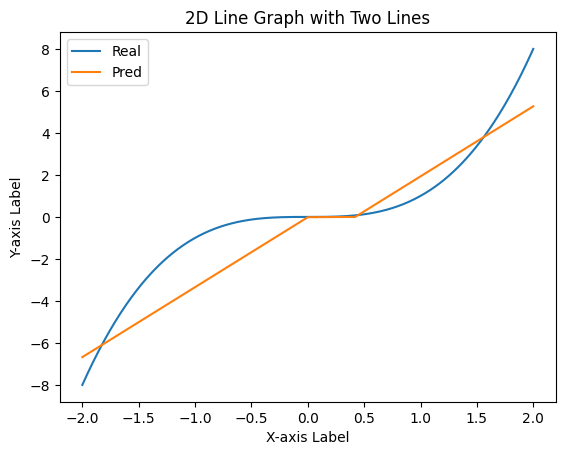

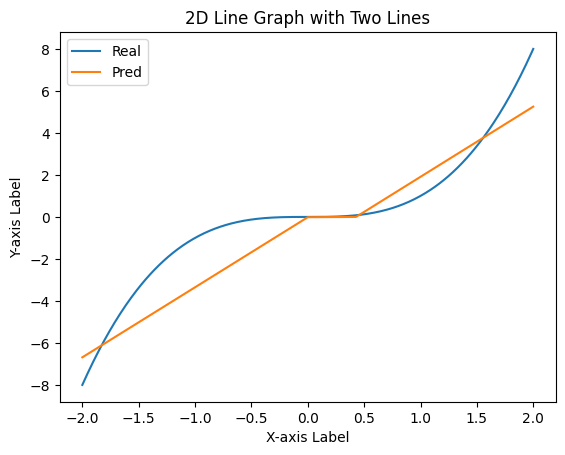

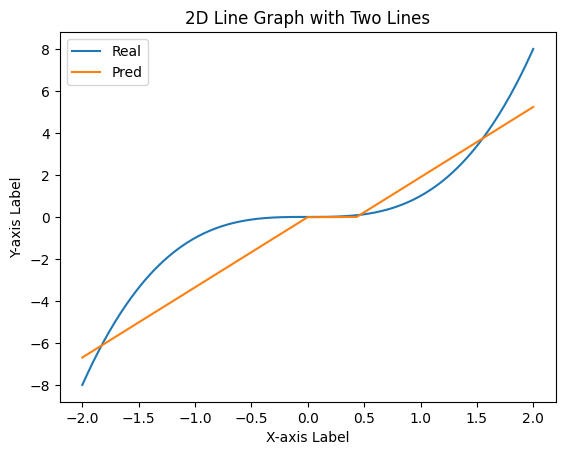

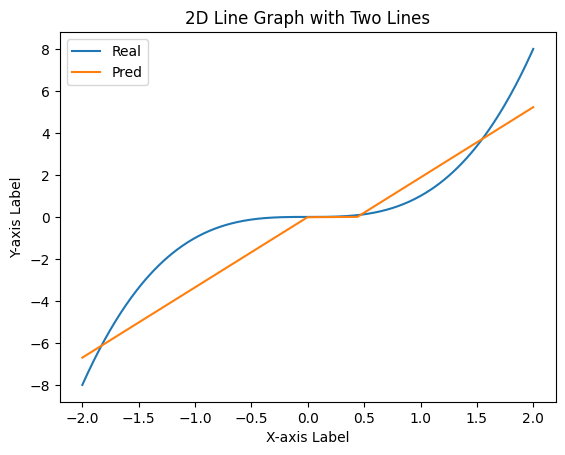

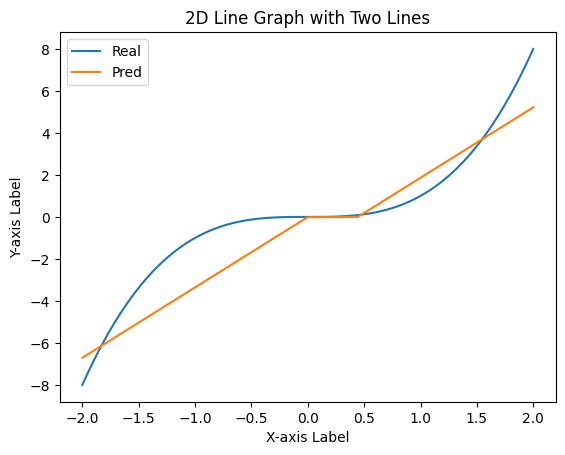

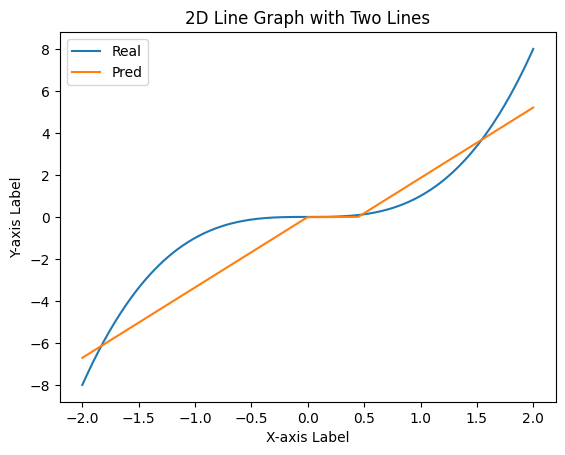

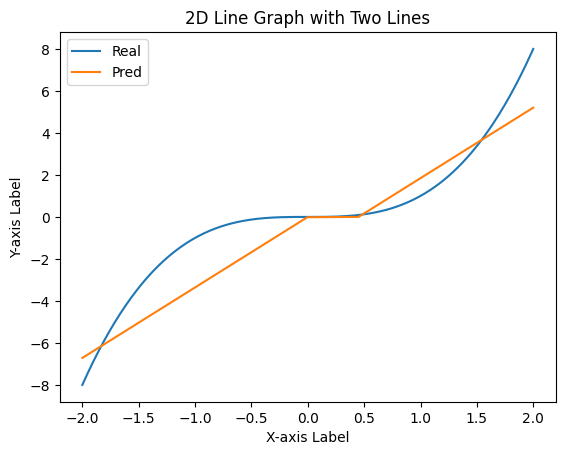

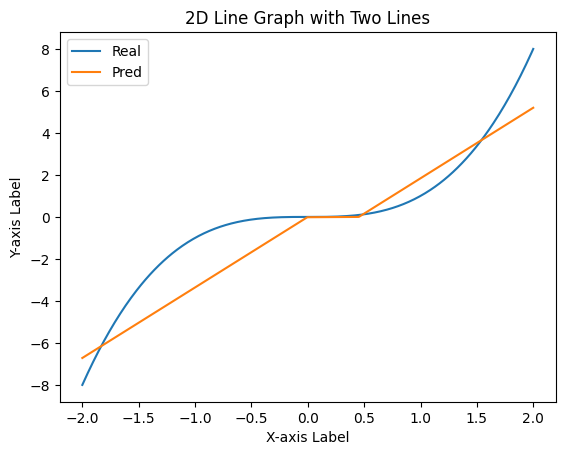

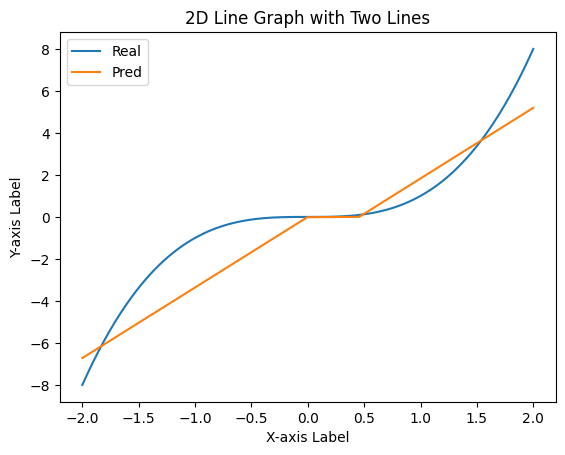

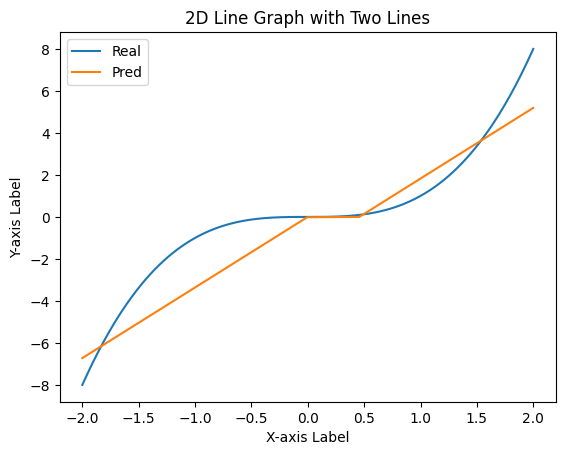

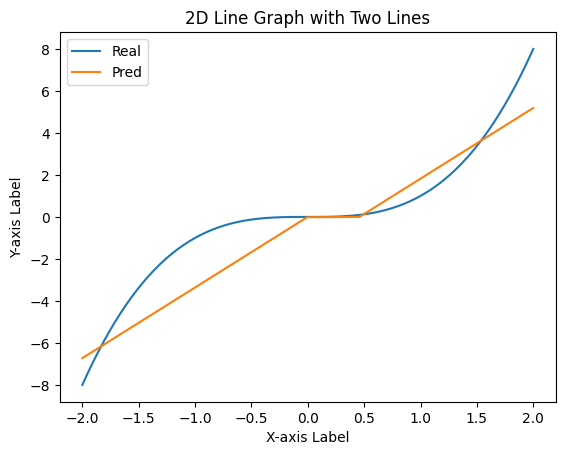

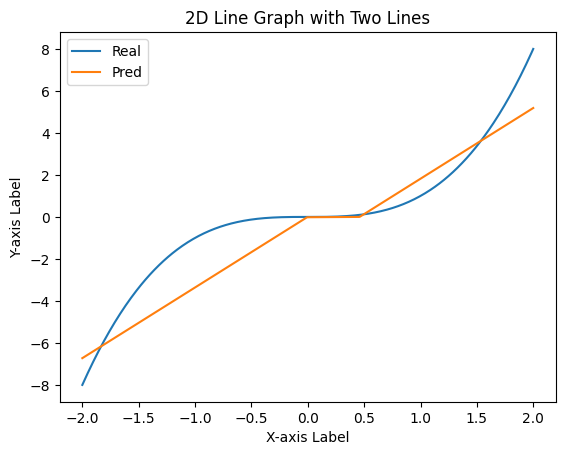

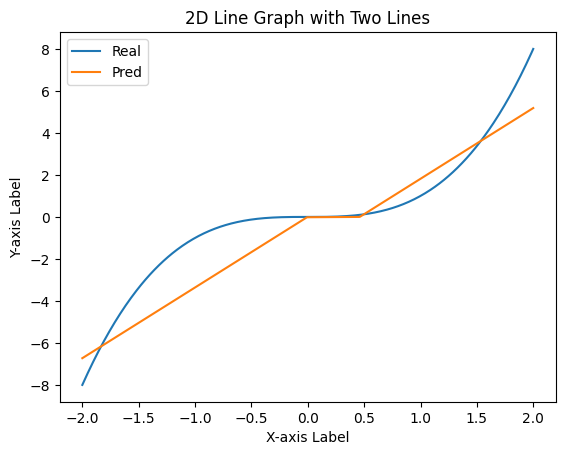

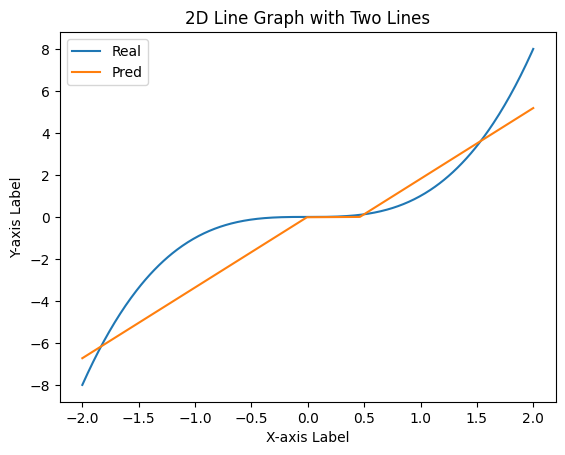

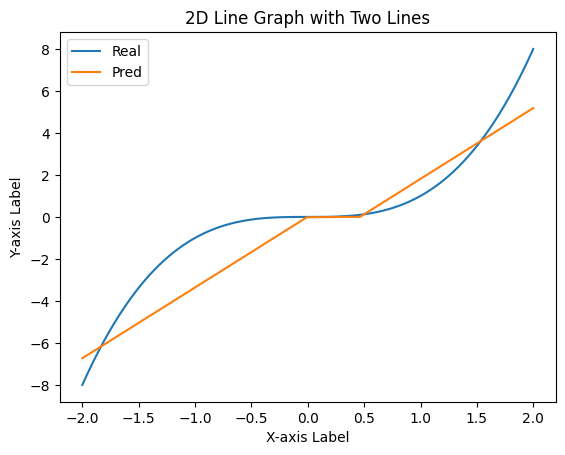

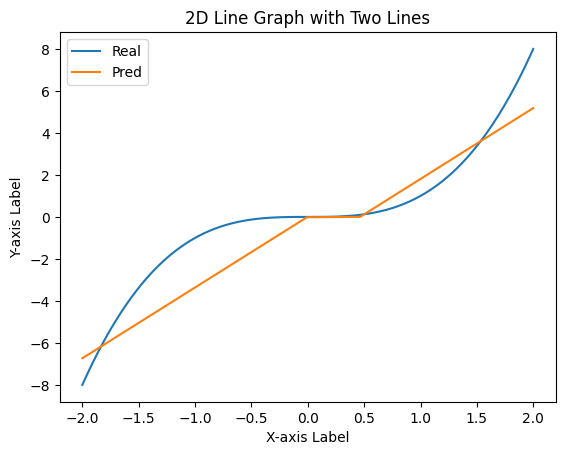

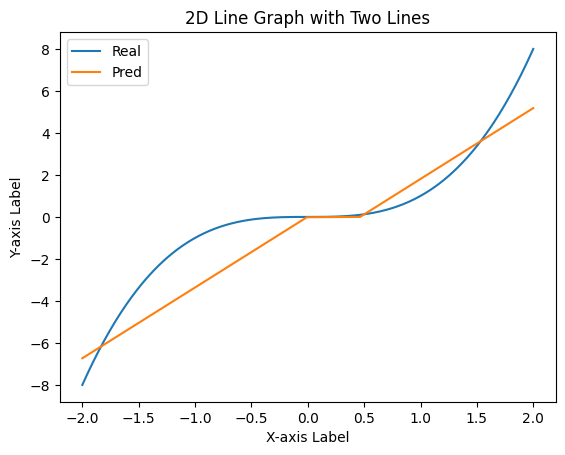

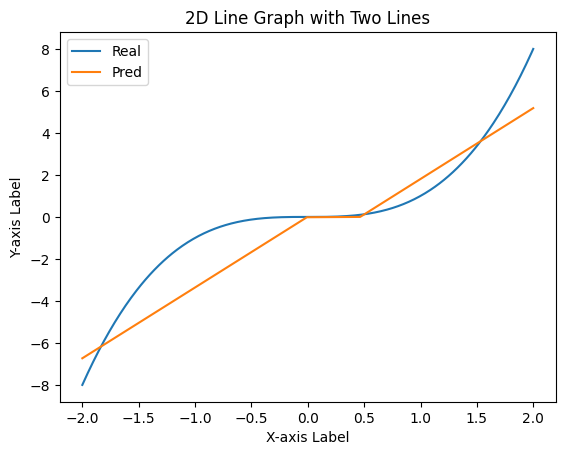

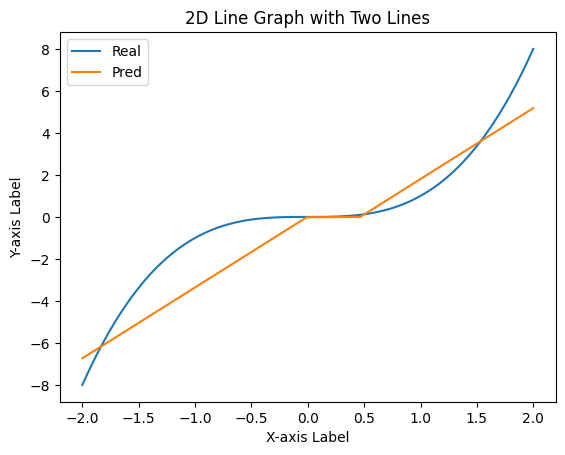

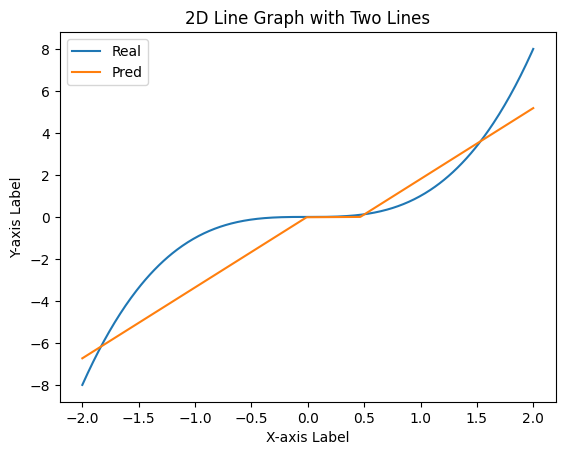

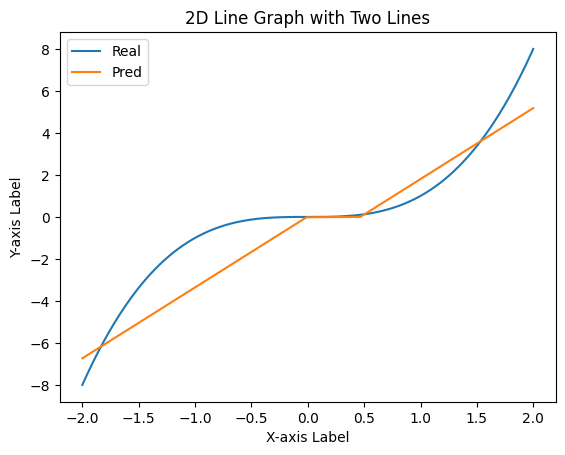

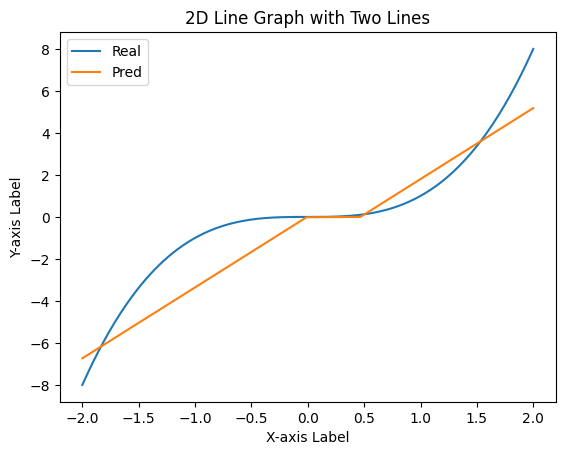

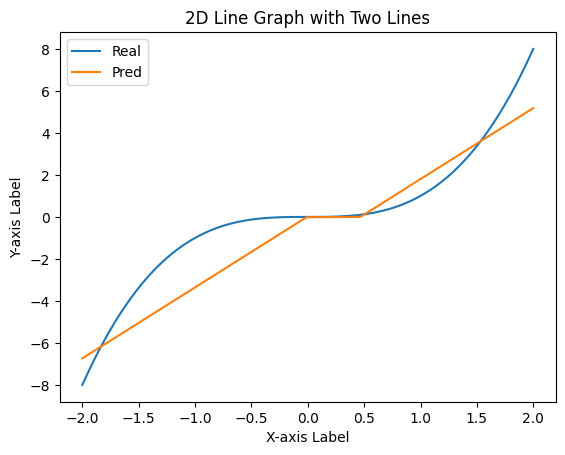

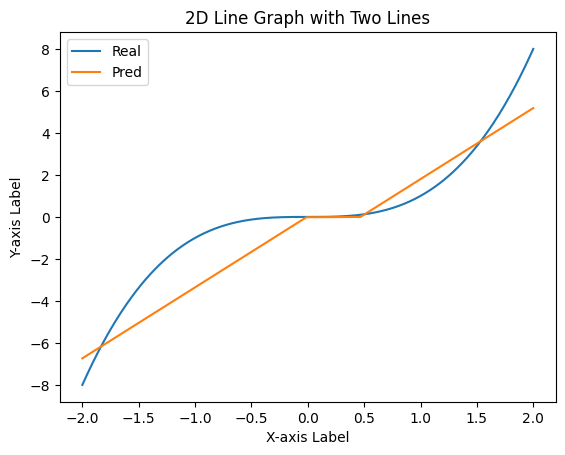

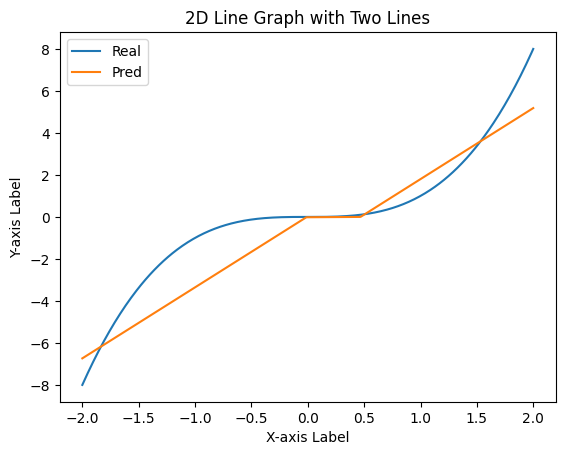

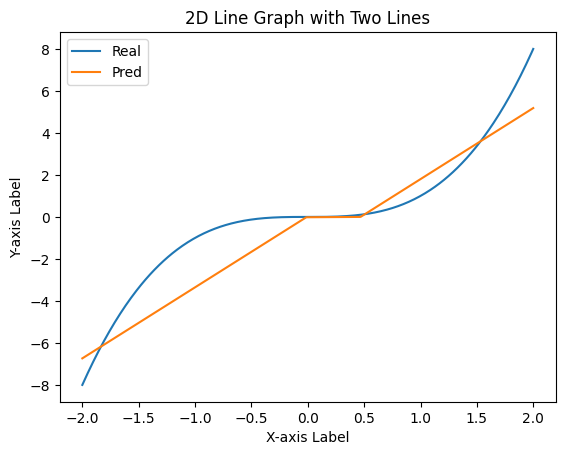

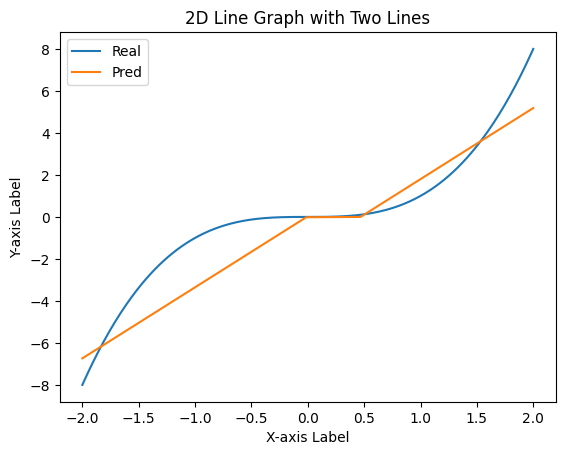

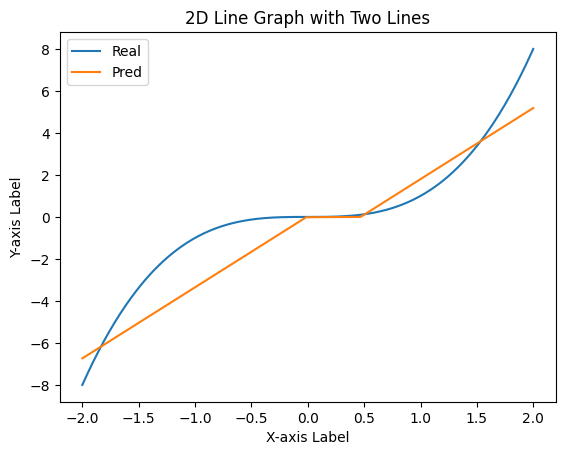

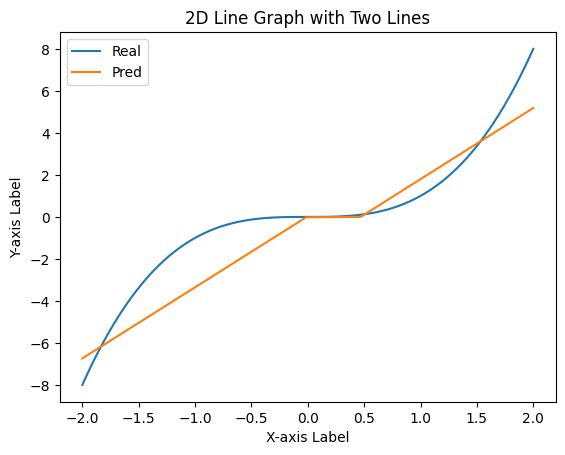

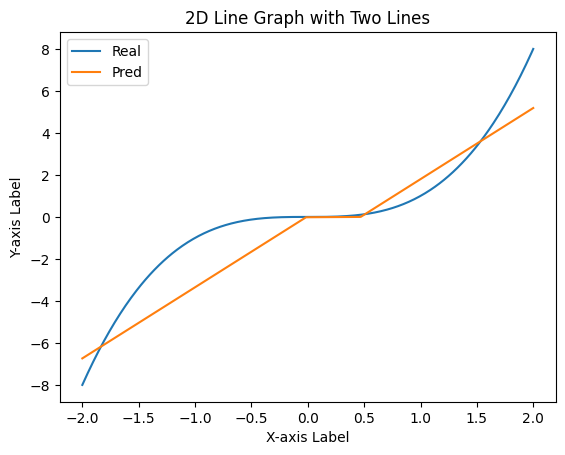

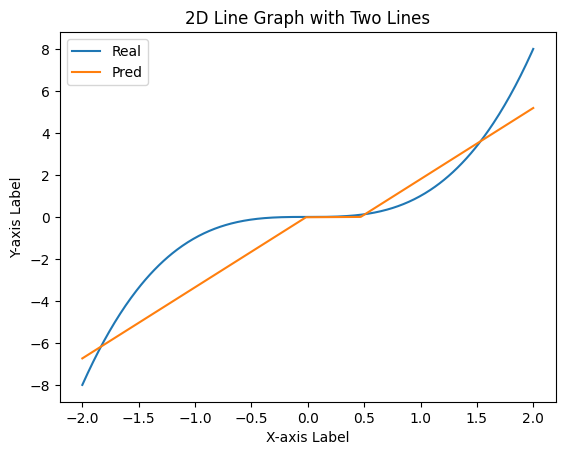

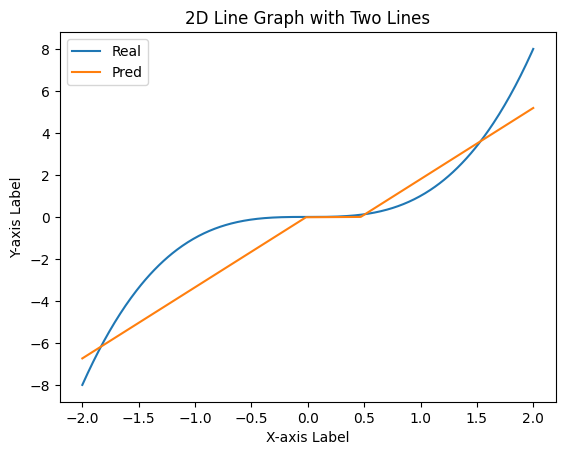

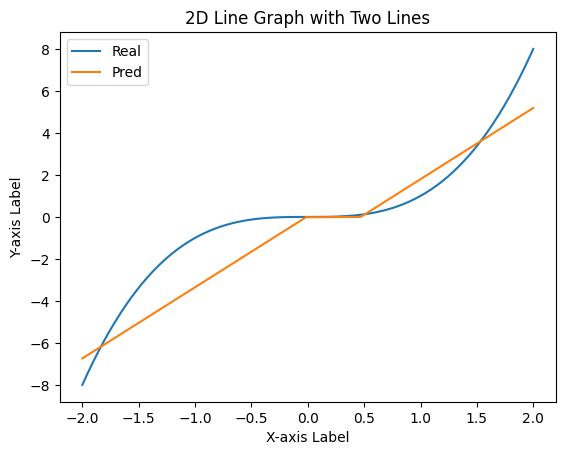

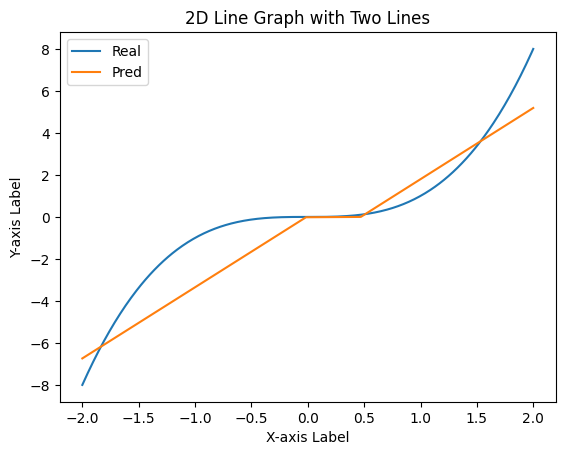

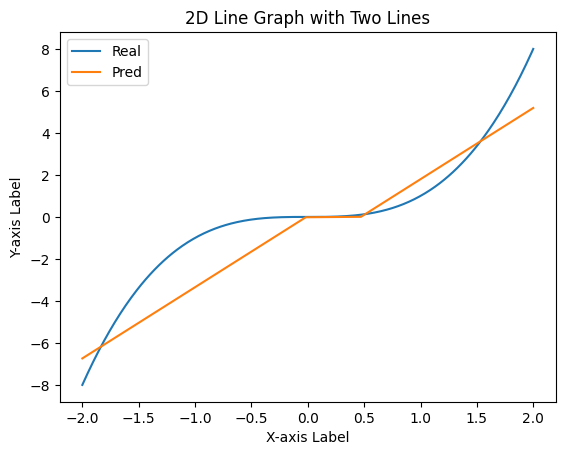

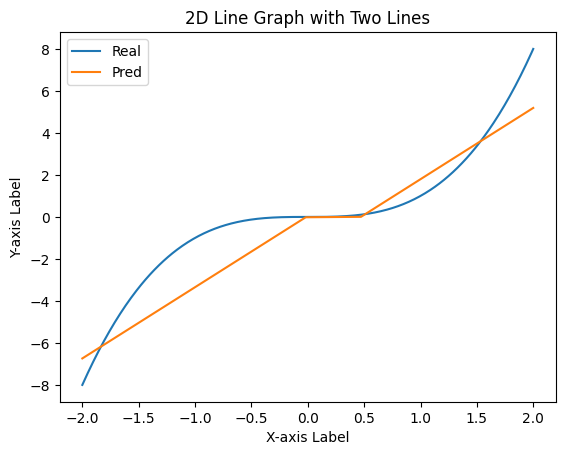

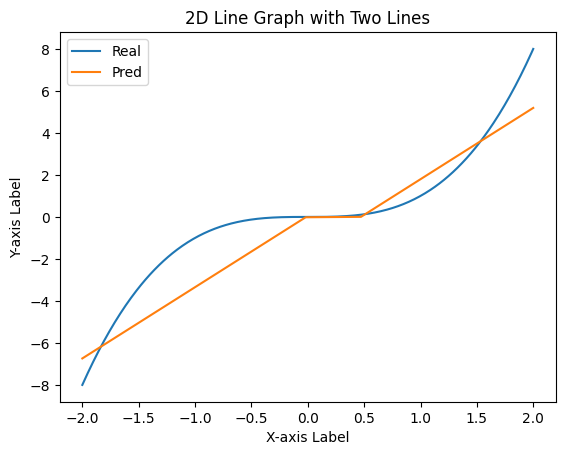

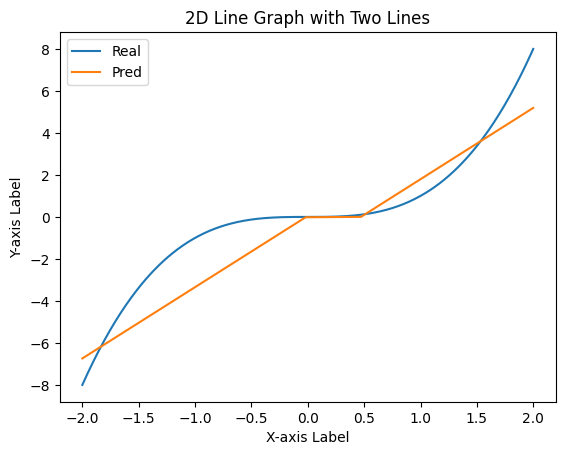

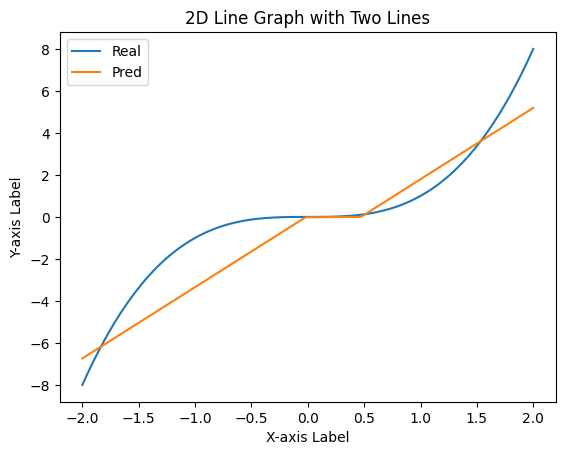

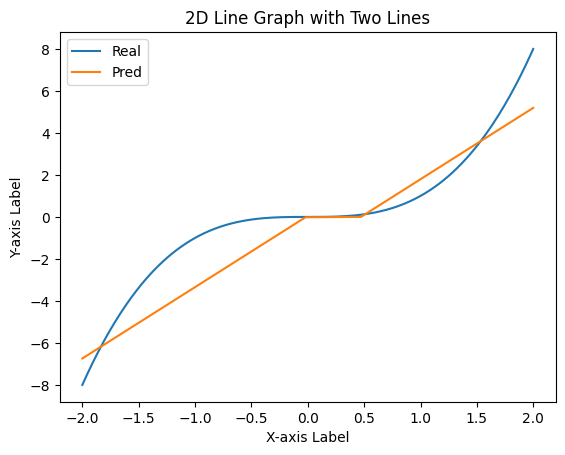

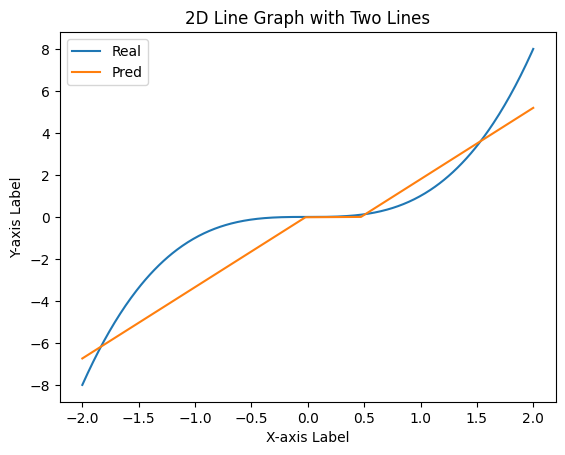

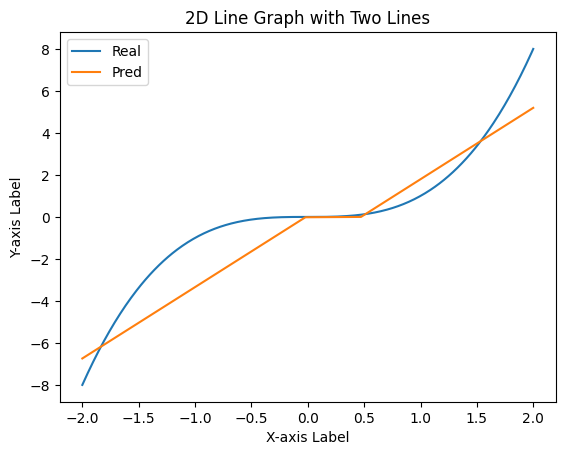

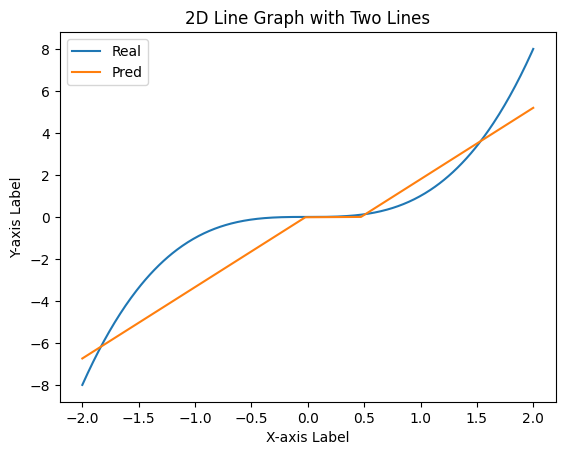

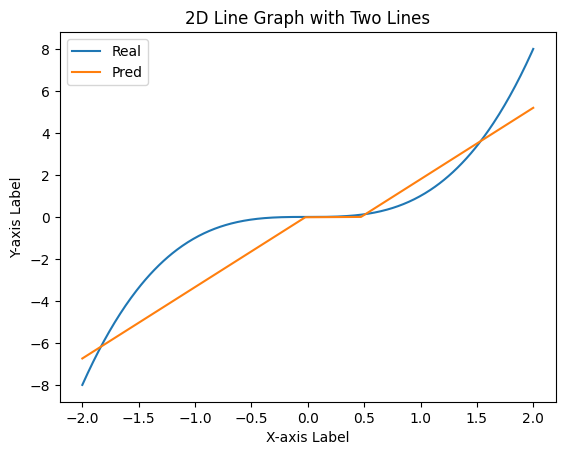

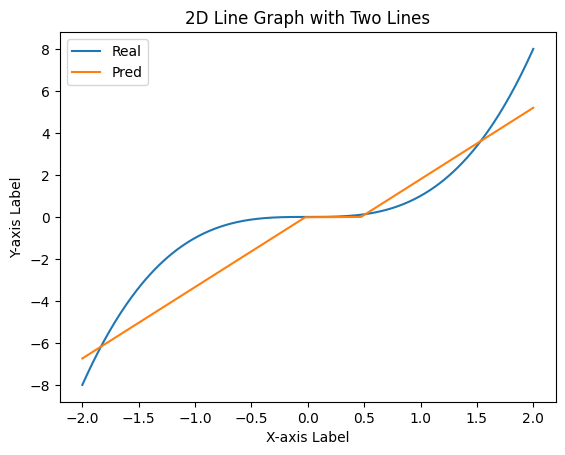

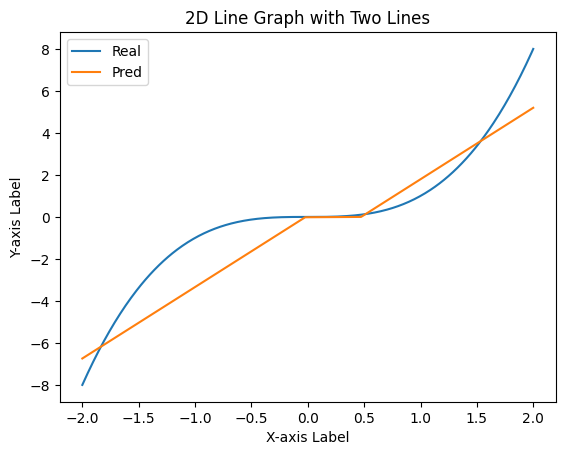

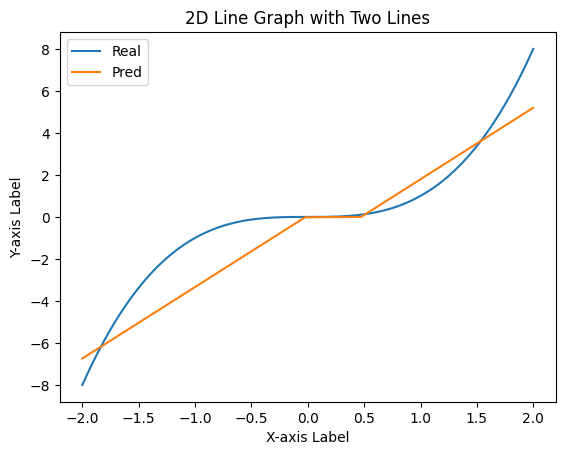

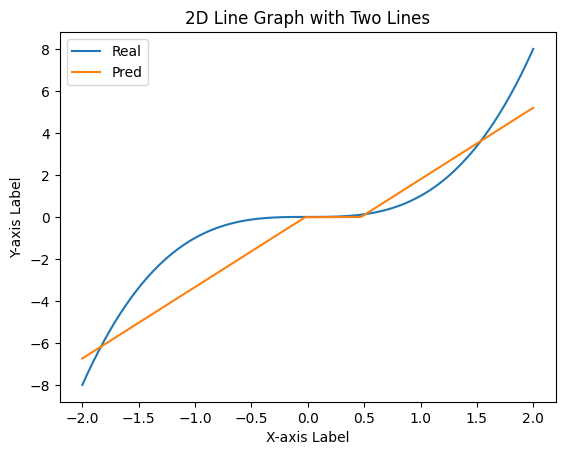

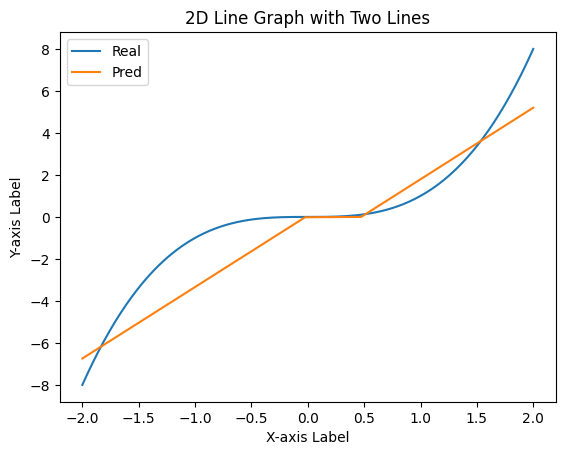

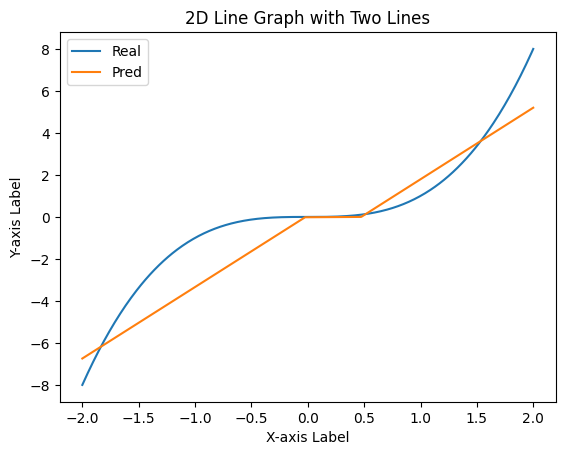

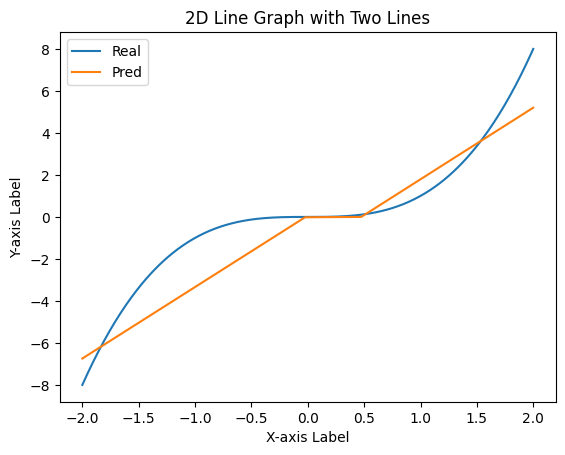

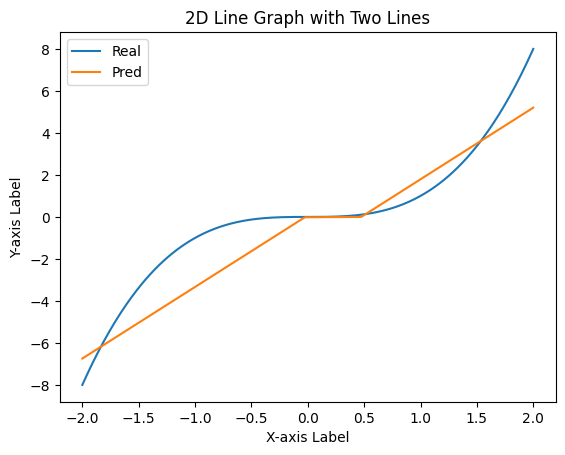

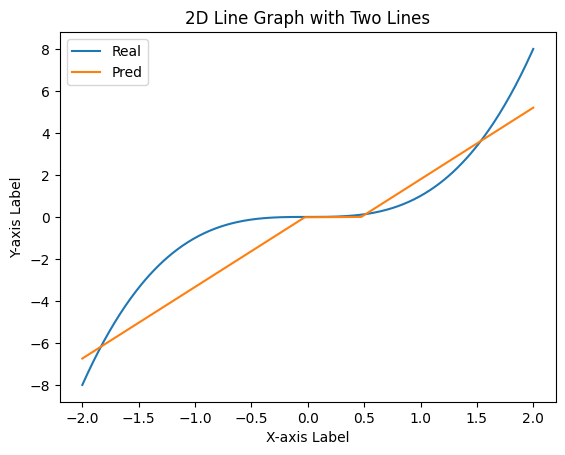

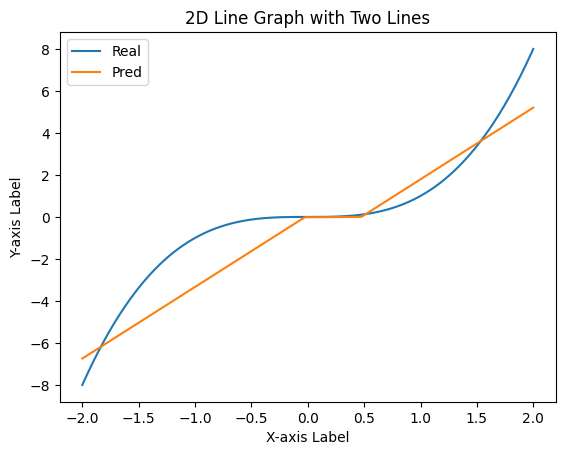

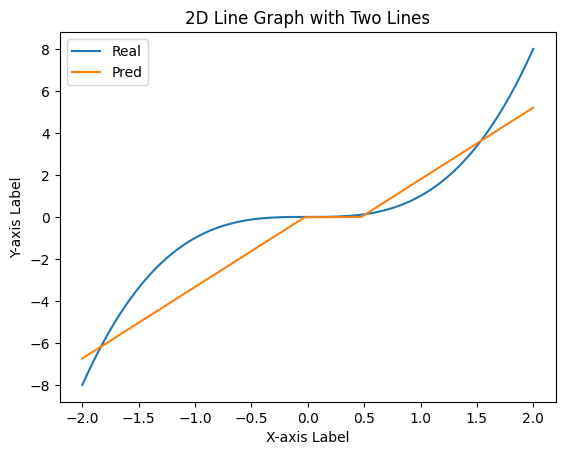

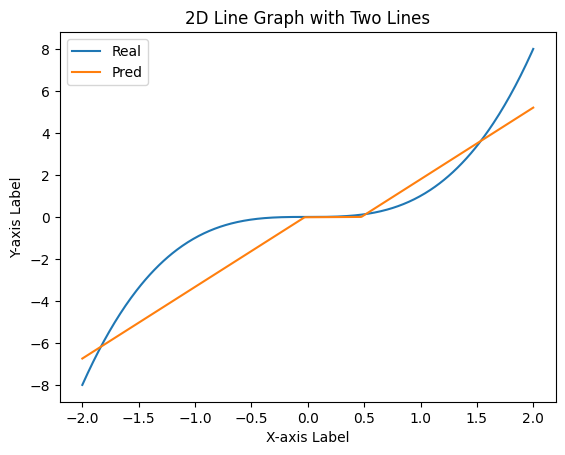

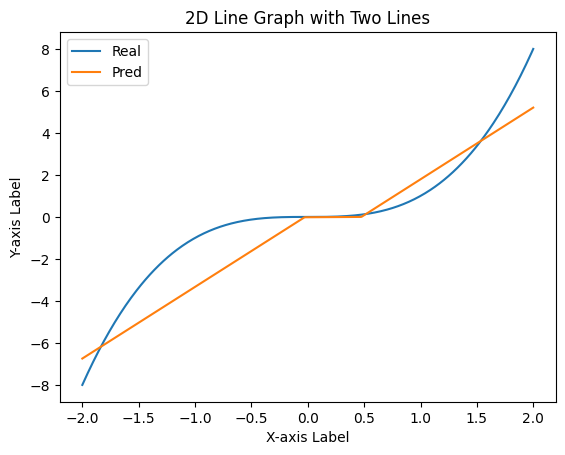

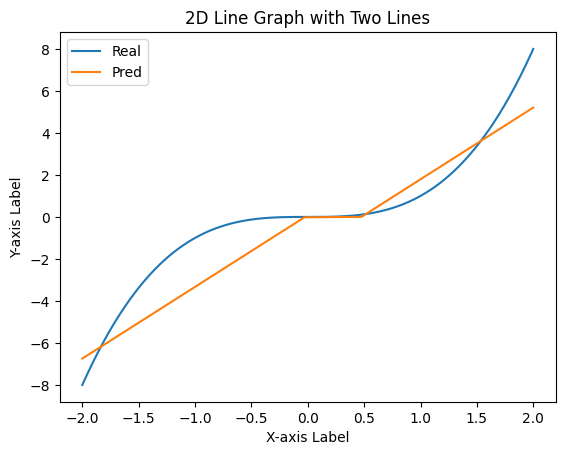

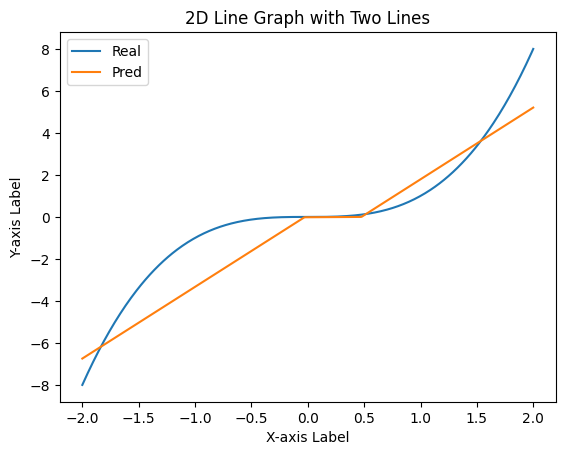

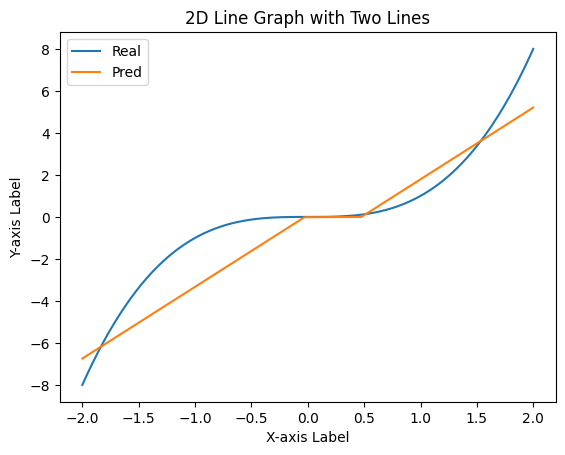

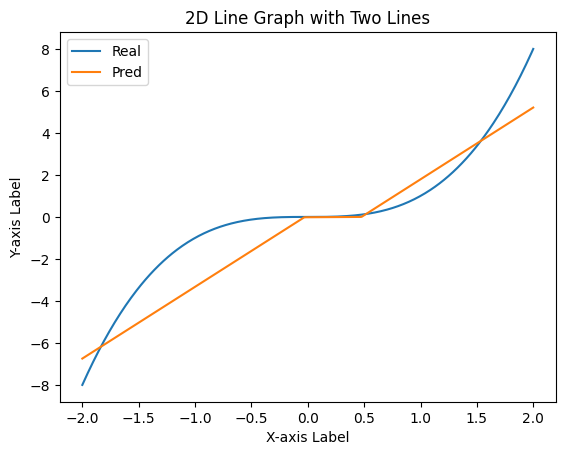

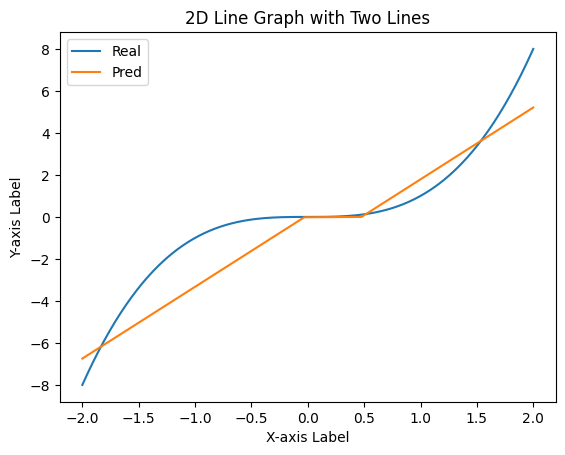

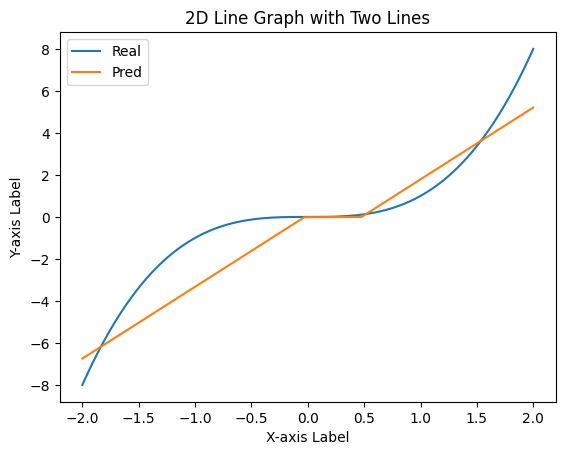

In [ ]:
start_time = time.time()
initial_cost = cost(NN.predict(X_train), y_train)
loss = initial_cost

iterations = 0
a = 5e-4
g = .9
while(loss>1e-4 and iterations<100):
  if (iterations>1):
    g = .5
  loss = fit(a, g, method="sgd")
  predictions = NN.predict(X_train)
  print_graph(predictions)
  iterations += 1
finish_time = time.time()

In [ ]:
print(f"Time for {iterations} iterations: {finish_time-start_time}, change in loss={initial_cost - loss}")

Time for 100 iterations: 241.9722397327423, change in loss=1904.7339988184438
